<h1 style="font-size:5em;color:red;background-color:black;padding:3em 1em;;text-align:center;font-family:mono;font-weight:900;"> 🗯OffensEval 2019🗯<h1>

In [13]:
# boilerplate code provided by keggle :(

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/olid-dataset/olid-annotation.txt
/kaggle/input/olid-dataset/testset-levela.tsv
/kaggle/input/olid-dataset/olid-training-v1.0.tsv
/kaggle/input/olid-dataset/labels-levelc.csv
/kaggle/input/olid-dataset/README.txt
/kaggle/input/olid-dataset/labels-levelb.csv
/kaggle/input/olid-dataset/testset-levelc.tsv
/kaggle/input/olid-dataset/labels-levela.csv
/kaggle/input/olid-dataset/testset-levelb.tsv


In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model  # Import the plot_model function
import warnings
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')  

In [15]:
# training data reading
df = pd.read_csv('/kaggle/input/olid-dataset/olid-training-v1.0.tsv',sep='\t')
df.set_index('id', inplace=True)
df.head()

,tweet,subtask_a,subtask_b,subtask_c
id,,,,
86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [16]:
# data for sub task b,c is completely ... ki bolbo..
df.isna().sum()

tweet           0
subtask_a       0
subtask_b    8840
subtask_c    9364
dtype: int64

In [17]:
df['subtask_a'].value_counts()

subtask_a
NOT    8840
OFF    4400
Name: count, dtype: int64

In [18]:
df['label_a'] = df['subtask_a'].replace({'NOT': 0, 'OFF': 1})

In [19]:
df['subtask_b'].value_counts()

subtask_b
TIN    3876
UNT     524
Name: count, dtype: int64

In [20]:
df['label_b'] = df['subtask_b'].replace({'TIN': 1, 'UNT': 0})

In [21]:
df['subtask_c'].value_counts()

subtask_c
IND    2407
GRP    1074
OTH     395
Name: count, dtype: int64

<h1 style="font-size:2em;color:red;background-color:black;padding:1em 1em;;text-align:center;font-family:mono;font-weight:900;">Subtask a<h1>

In [22]:
# categorial to numerical
df['label_a'] = df['subtask_a'].replace({'NOT': 0, 'OFF': 1})

In [23]:
# for sub-task a
X = df['tweet'].values
y = df['label_a'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# tokenize the text data
max_words = 160

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# pad the sequences to have the same length
max_sequence_length = 160
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# batch size
batch_size = 64


# now creating the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_sequence_length,), batch_size=batch_size),
    tf.keras.layers.Embedding(max_words, 128, input_length=max_sequence_length),
    tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
epochs = 3
model.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_padded, y_test))

# evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/3
166/166 [==============================] - 65s 370ms/step - loss: 0.6362 - accuracy: 0.6698 - val_loss: 0.6503 - val_accuracy: 0.6545
Epoch 2/3
166/166 [==============================] - 62s 373ms/step - loss: 0.6344 - accuracy: 0.6710 - val_loss: 0.6464 - val_accuracy: 0.6545
Epoch 3/3
83/83 [==============================] - 3s 40ms/step - loss: 0.6448 - accuracy: 0.6545
Test Loss: 0.6448
Test Accuracy: 0.6545


In [24]:
# evaluate the model's performance
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# now generate a classification report
y_pred = model.predict(X_test_padded)
y_pred_binary = (y_pred > 0.5).astype(int)

classification_rep = classification_report(y_test, y_pred_binary)
print("Classification Report:")
print(classification_rep)

83/83 [==============================] - 3s 38ms/step - loss: 0.6448 - accuracy: 0.6545
Test Loss: 0.6448
Test Accuracy: 0.6545
83/83 [==============================] - 3s 38ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      1733
           1       0.00      0.00      0.00       915

    accuracy                           0.65      2648
   macro avg       0.33      0.50      0.40      2648
weighted avg       0.43      0.65      0.52      2648



In [25]:
model

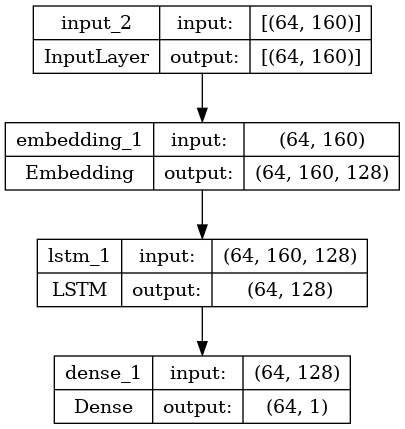

In [26]:
# Generate and save a graphical representation of the model
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

<h1 style="font-size:2em;color:red;background-color:black;padding:1em 1em;;text-align:center;font-family:mono;font-weight:900;">Subtask b<h1>

In [27]:
# before dropping
df['subtask_b'].value_counts()

subtask_b
TIN    3876
UNT     524
Name: count, dtype: int64

In [28]:
# droppign null as subtask b has most of the data as undefined
df = df.dropna()

In [29]:
# after dropping
df['subtask_b'].value_counts()

subtask_b
TIN    3876
Name: count, dtype: int64

In [30]:
# categorial to numerical
df['label_b'] = df['subtask_b'].replace({'UNT': 0, 'TIN': 1})

In [31]:
# for sub-task b
X = df['tweet'].values
y = df['label_b'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# tokenize the text data
max_words = 160

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# pad the sequences to have the same length
max_sequence_length = 160
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# batch size
batch_size = 64


# now creating the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_sequence_length,), batch_size=batch_size),
    tf.keras.layers.Embedding(max_words, 128, input_length=max_sequence_length),
    tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
epochs = 10
model.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_padded, y_test))

# evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/10
49/49 [==============================] - 21s 370ms/step - loss: 0.0696 - accuracy: 0.9981 - val_loss: 4.6669e-05 - val_accuracy: 1.0000
Epoch 2/10
49/49 [==============================] - 18s 371ms/step - loss: 3.8693e-05 - accuracy: 1.0000 - val_loss: 3.1140e-05 - val_accuracy: 1.0000
Epoch 3/10
49/49 [==============================] - 18s 358ms/step - loss: 2.8720e-05 - accuracy: 1.0000 - val_loss: 2.4404e-05 - val_accuracy: 1.0000
Epoch 4/10
49/49 [==============================] - 17s 354ms/step - loss: 2.2922e-05 - accuracy: 1.0000 - val_loss: 1.9860e-05 - val_accuracy: 1.0000
Epoch 5/10
49/49 [==============================] - 18s 364ms/step - loss: 1.8900e-05 - accuracy: 1.0000 - val_loss: 1.6503e-05 - val_accuracy: 1.0000
Epoch 6/10
49/49 [==============================] - 17s 353ms/step - loss: 1.5815e-05 - accuracy: 1.0000 - val_loss: 1.3901e-05 - val_accuracy: 1.0000
Epoch 7/10
49/49 [==============================] - 18s 361ms/step - loss: 1.3455e-05 - accuracy: 

In [32]:
# evaluate the model's performance
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# now generate a classification report
y_pred = model.predict(X_test_padded)
y_pred_binary = (y_pred > 0.5).astype(int)

classification_rep = classification_report(y_test, y_pred_binary)
print("Classification Report:")
print(classification_rep)

25/25 [==============================] - 1s 37ms/step - loss: 8.3496e-06 - accuracy: 1.0000
Test Loss: 0.0000
Test Accuracy: 1.0000
25/25 [==============================] - 1s 38ms/step
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       776

    accuracy                           1.00       776
   macro avg       1.00      1.00      1.00       776
weighted avg       1.00      1.00      1.00       776



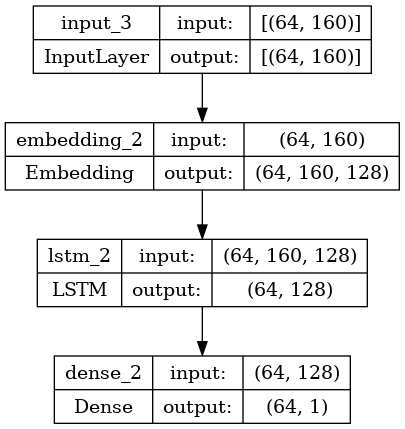

In [33]:
# Generate and save a graphical representation of the model
plot_model(model, to_file='lstm_model_for_subtask_b_but_same_model.png', show_shapes=True, show_layer_names=True)

In [34]:
model